In [5]:
## install hugging face tranformers lib. and torch lib.
!pip install transformers==3.5.1
!pip install torch==1.4.0
!pip install datasets 

## **Load Dataset from HuggingFace for fine tuning**

In [9]:
from datasets import list_datasets, load_dataset

all_datasets = list_datasets()
emotion_ds_metadata = list_datasets(with_details=True)[all_datasets.index("emotion")]
print(emotion_ds_metadata)

Dataset Name: emotion, Tags: ['pretty_name:Emotion', 'annotations_creators:machine-generated', 'language_creators:machine-generated', 'languages:en', 'licenses:unknown', 'multilinguality:monolingual', 'size_categories:10K<n<100K', 'source_datasets:original', 'task_categories:text-classification', 'task_ids:multi-class-classification', 'task_ids:text-classification-other-emotion-classification']


In [10]:
## Load emotion dataset from huggingface https://huggingface.co/datasets/emotion
emotions = load_dataset("emotion")  

emotions

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [12]:
train_ds = emotions["train"]
test_ds = emotions["test"]

In [13]:
train_ds.features

{'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], names_file=None, id=None),
 'text': Value(dtype='string', id=None)}

In [14]:
train_ds[:5]

{'label': [0, 0, 3, 2, 3],
 'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy']}

In [88]:
import pandas as pd

emotions.set_format(type="pandas")
df_train = emotions["train"][:]
df_test = emotions["test"][:]
df_train.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


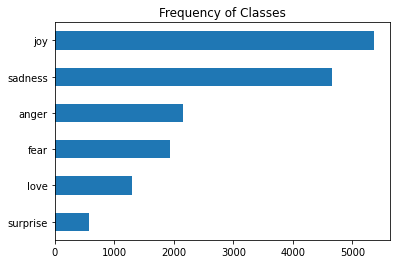

In [103]:
# Checking Class distribution

import matplotlib.pyplot as plt

def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df_train["label_name"] = df_train["label"].apply(label_int2str)

df_train["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


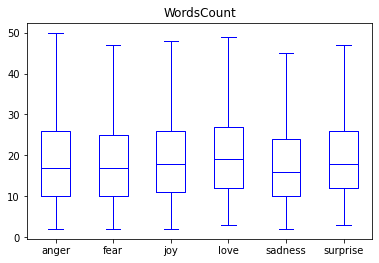

In [104]:
## check average word count in text. 
## it is helpful to set max_length, one of the param while token encoding

df_train["WordsCount"] = df_train["text"].str.split().apply(len)
df_train.boxplot("WordsCount", by="label_name", grid=False, showfliers=False, color="blue")
plt.suptitle("")
plt.xlabel("")
plt.show()

average word count in text is around 15 ,
it is helpful to set max_length while token encoding and padding

## **Load SequenceClassification model and tokenizer**

In [138]:
## Since we are using Seq. classification , We will use BertForSequenceClassification class of pre-trained model 
##from transformers import BertForSequenceClassification 
from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch

In [105]:
# Use bert-base-uncased model which is not case sensitive
# Find more details at https://huggingface.co/bert-base-uncased
Model_Name="bert-base-uncased"

In [150]:
##model=BertForSequenceClassification.from_pretrained(Model_Name)
##model=AutoModel.from_pretrained(Model_Name)
num_labels = 6  ## (joy, sadness, anger, fear, love, surprise )
model = AutoModelForSequenceClassification.from_pretrained(Model_Name, num_labels=num_labels)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [26]:
## We will use BertTokenizerFast instead of BertTokenizer ( https://huggingface.co/docs/transformers/main_classes/tokenizer )
from transformers import BertTokenizerFast 

tokenizer=BertTokenizerFast.from_pretrained(Model_Name)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

## **PreProcess Data for Input to BERT model**

In [107]:
pad_max_length=15 # which we checked earlier

# creating seperate method to tokenize since we need to apply this method on entire train/test dataset.  
def tokenize(data_to_tokenize):
   return tokenizer(list(data_to_tokenize['text']), padding=True, truncation=True , max_length=pad_max_length)
  

In [126]:
emotions_encoded_train = emotions["train"].map(tokenize, batched=True, batch_size=None)
emotions_encoded_test = emotions["test"].map(tokenize, batched=True, batch_size=None)


Loading cached processed dataset at /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705/cache-05422aa3de004c1e.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705/cache-f142e1f8eb6e9c58.arrow


In [127]:
emotions_encoded_train

Dataset({
    features: ['attention_mask', 'input_ids', 'label', 'text', 'token_type_ids'],
    num_rows: 16000
})

In [129]:
## convert format
emotions_encoded_train.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
emotions_encoded_test.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

In [146]:
emotions_encoded_train["label"]

tensor([0, 0, 3,  ..., 1, 3, 0])

## **Train BERT Model on dataset** 

In [140]:
batch_size = 8
epochs = 2
warmup_steps = 500
weight_decay = 0.01

In [141]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_steps= warmup_steps,
    weight_decay=weight_decay,
    evaluate_during_training=True,
    logging_dir='./logs',
)

/usr/local/lib/python3.7/dist-packages/transformers/training_args.py:347: FutureWarning: The `evaluate_during_training` argument is deprecated in favor of `evaluation_strategy` (which has more options)
  FutureWarning,


In [152]:
# define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=emotions_encoded_train,
    eval_dataset=emotions_encoded_test
)

In [153]:
# train model

trainer.train()

Step,Training Loss,Validation Loss
500,1.305199,0.816532
1000,0.789173,0.791235
1500,0.692891,0.710763
2000,0.654309,0.634900
2500,0.544613,0.618900
3000,0.542478,0.618048
3500,0.492085,0.607649
4000,0.494901,0.607506


TrainOutput(global_step=4000, training_loss=0.6894561157226563)

In [154]:
# evalute model
trainer.evaluate()

{'epoch': 2.0, 'eval_loss': 0.607505738735199}

In [155]:
emotions_encoded_validation = emotions["validation"].map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
emotions_encoded_validation.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

In [158]:
# predict on validation
preds_output = trainer.predict(emotions_encoded_validation)

In [159]:
preds_output.metrics

{'eval_loss': 0.5829975605010986}

In [160]:
preds_output.predictions

array([[ 6.7057858 , -1.2770245 , -1.2509085 , -1.4623513 , -1.1806632 ,
        -2.8581858 ],
       [ 6.638301  , -1.2367635 , -1.45705   , -1.0268338 , -1.4029143 ,
        -2.7166822 ],
       [-1.2607988 ,  3.4821086 ,  3.7258167 , -2.4599428 , -2.272837  ,
        -0.79045457],
       ...,
       [-1.0893759 ,  6.6244183 , -0.9237916 , -1.9654679 , -1.567494  ,
        -0.84782135],
       [-1.4161296 ,  3.6608107 ,  3.122416  , -2.4796767 , -1.9809544 ,
        -0.7523423 ],
       [-1.4623992 ,  6.4330535 , -1.0397961 , -2.0701838 , -1.2634183 ,
        -0.35047066]], dtype=float32)

In [161]:
preds_output.label_ids

array([0, 0, 2, ..., 1, 1, 1])

In [162]:
import numpy as np

#take max probability from each prediction
y_preds = np.argmax(preds_output.predictions, axis=1)

In [165]:
y_valid = np.array(emotions["validation"]["label"])
labels=emotions["train"].features["label"].names

## **Confusion Matrix**

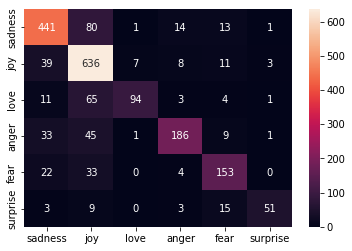

In [173]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_valid, y_preds)
f = sns.heatmap(cm, annot=True, fmt='d' ,xticklabels=labels, yticklabels=labels)